In [1]:
import os
import gc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [3]:
from tensorflow import keras
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
ecg_expert = pd.read_csv('ECG_expert_features.csv', index_col=0)
ecg_expert.head(5)

,pid,lab,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,lf,hf,lf/hf
S10_000,S10,Base,100.351586,597.897874,20.918173,3.974686,6.208745,0.000000,0.0,15.62500,4.371335,29.151830,400.340724,0.149951,0.069023,4317.830834,886.033184,4.873216
S10_001,S10,Base,101.107492,593.427835,19.516506,4.361267,6.585369,0.000000,0.0,11.71875,4.647473,27.295107,398.521312,0.170268,0.121707,1633.377329,646.859113,2.525090
S10_002,S10,Base,101.610857,590.488080,18.094553,5.043338,7.379010,0.010526,0.0,11.71875,5.211182,25.070505,410.439547,0.207861,0.069896,4289.566142,420.117395,10.210399
S10_003,S10,Base,102.648846,584.517045,18.080210,4.874242,6.949337,0.010309,0.0,11.71875,4.907236,25.190906,388.356480,0.194802,0.069183,11034.009898,871.615284,12.659266
S10_004,S10,Base,103.052318,582.228535,17.769968,4.959666,7.270157,0.010309,0.0,11.71875,5.140778,24.741109,399.574576,0.207783,0.069453,14116.895674,1392.987428,10.134259


In [7]:
ecg_expert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3199 entries, S10_000 to S9_211
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pid            3199 non-null   object 
 1   lab            3199 non-null   object 
 2   bpm            3199 non-null   float64
 3   ibi            3199 non-null   float64
 4   sdnn           3199 non-null   float64
 5   sdsd           3199 non-null   float64
 6   rmssd          3199 non-null   float64
 7   pnn20          3199 non-null   float64
 8   pnn50          3199 non-null   float64
 9   hr_mad         3199 non-null   float64
 10  sd1            3199 non-null   float64
 11  sd2            3199 non-null   float64
 12  s              3199 non-null   float64
 13  sd1/sd2        3199 non-null   float64
 14  breathingrate  3199 non-null   float64
 15  lf             3199 non-null   float64
 16  hf             3199 non-null   float64
 17  lf/hf          3199 non-null   float64
dtypes: fl

In [6]:
ecg_expert.describe()

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,lf,hf,lf/hf
count,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3199.000000,3.199000e+03,3.199000e+03,3199.000000
mean,80.662209,778.932925,68.214313,30.405282,47.280005,0.506018,0.235460,45.479300,33.246691,88.592962,10932.294375,0.373138,0.120212,3.705577e+43,7.967254e+46,3.994220
std,19.495826,155.005556,29.983841,19.748978,31.545604,0.235930,0.201243,23.294007,21.890124,38.379289,11800.780974,0.163020,0.106801,2.095863e+45,4.506255e+48,5.624331
min,50.666315,248.263889,11.424330,0.000000,4.360596,0.000000,0.000000,7.812500,0.000000,0.000000,0.000000,0.083261,0.040235,0.000000e+00,0.000000e+00,0.000000
25%,68.920100,688.181323,47.441935,17.641069,27.012776,0.338710,0.065789,29.296875,19.044313,61.241041,4017.152993,0.257849,0.068072,3.189891e+04,1.253283e+04,1.014948
50%,76.181029,787.597656,62.972445,25.520542,40.249355,0.539474,0.189189,41.015625,28.430870,82.681692,7471.498163,0.333648,0.092625,6.763827e+04,3.046672e+04,2.352720
75%,87.186324,870.573317,83.935984,37.667085,57.918097,0.693333,0.363636,58.593750,40.748777,109.284867,13641.033008,0.463232,0.119235,1.308992e+05,7.020529e+04,4.928540
max,241.678322,1184.218750,233.234203,227.910152,333.036927,1.000000,1.000000,175.781250,233.695444,273.647490,175691.467479,1.817113,1.637018,1.185414e+47,2.548724e+50,86.421220


In [34]:
def class_to_number(labels):
    # This function converts classes from categories to numbers, e.g. "Base" to 0, "Fun" to 1, etc.
    classes = np.unique(labels)
    for c in range(len(classes)):
        labels[labels == classes[c]] = c    

    return np.array(labels, dtype=int)

In [35]:
def one_hot_encoding(labels, num_classes):
    # This function performs one hot encoding for labels
    if type(labels[0]) == str:
        labels = class_to_number(labels)
    elif type(labels[0]) == float:
        labels = int(labels)
    Y = np.eye(num_classes)[labels]
    
    return Y

In [36]:
train_participants = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14']
test_participants  = ['S15', 'S16', 'S17']

In [37]:
# Subsample indices for each set
train_idx = ecg_expert[ecg_expert.pid.isin(train_participants)].index
test_idx = ecg_expert[ecg_expert.pid.isin(test_participants)].index

In [38]:
# Split data
X_train = ecg_expert.loc[train_idx].iloc[:,2:].to_numpy()    # iloc[:,2:] drops first two columns (pid and lab)
y_train = ecg_expert.loc[train_idx].lab.to_numpy()
y_train = class_to_number(y_train)

In [39]:

X_test  = ecg_expert.loc[test_idx].iloc[:,2:].to_numpy()
y_test  = ecg_expert.loc[test_idx].lab.to_numpy()
y_test  = class_to_number(y_test)

In [40]:
# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm  = scaler.transform(X_test)

In [41]:
# Define classifier (SVM for classification) with default parameters
clf = SVC()

# Fit it to train data
clf.fit(X_train_norm, y_train)

# Make predictions
pred_classical = clf.predict(X_test_norm)

In [42]:
print('Accuracy (SVM):    ', (np.round(accuracy_score(pred_classical, y_test), 3)))
print('F1 score (SVM):    ', (np.round(f1_score(pred_classical, y_test, average = 'macro'), 3)))
print('UAR (SVM):         ', (np.round(recall_score(pred_classical, y_test, average = 'macro'), 3)))

Accuracy (SVM):     0.739
F1 score (SVM):     0.552
UAR (SVM):          0.525


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [44]:
# Define classifier (SVM for classification) with default parameters
KNN = KNeighborsClassifier()

# Fit it to train data
KNN.fit(X_train_norm, y_train)

# Make predictions
pred_classical = KNN.predict(X_test_norm)

In [45]:
print('Accuracy (KNN):    ', (np.round(accuracy_score(pred_classical, y_test), 3)))
print('F1 score (KNN):    ', (np.round(f1_score(pred_classical, y_test, average = 'macro'), 3)))
print('UAR (KNN):         ', (np.round(recall_score(pred_classical, y_test, average = 'macro'), 3)))

Accuracy (KNN):     0.618
F1 score (KNN):     0.51
UAR (KNN):          0.502


In [46]:
# Define classifier (SVM for classification) with default parameters
randomClassifier = RandomForestClassifier()

# Fit it to train data
randomClassifier.fit(X_train_norm, y_train)

# Make predictions
pred_classical = randomClassifier.predict(X_test_norm)

In [47]:
print('Accuracy (Random Forest):    ', (np.round(accuracy_score(pred_classical, y_test), 3)))
print('F1 score (Random Forest):    ', (np.round(f1_score(pred_classical, y_test, average = 'macro'), 3)))
print('UAR (Random Forest):         ', (np.round(recall_score(pred_classical, y_test, average = 'macro'), 3)))

Accuracy (Random Forest):     0.594
F1 score (Random Forest):     0.515
UAR (Random Forest):          0.515


#### Fully Supervised Deep Learning Approach

#### Using CNN to recognize affect. 


In [48]:
# Function reads the data according to participants list taken as a parameter
def read_data(participants):
    X = []
    
    for filename in train_participants:
        temp = pd.read_csv('data/{}.csv'.format(filename), index_col=0)
        X.append(temp)
        
    X = pd.concat(X, axis = 0)
    y = X.lab.to_numpy()
    y = class_to_number(y)
    X = X.iloc[:,2:].to_numpy()
    
    return X, y

In [49]:
# Define train and test sets
train_participants = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10']
devel_participants = ['S11', 'S13', 'S14']
test_participants  = ['S15', 'S16', 'S17']

In [50]:
# Read files for train and test participants
X_train, y_train = read_data(train_participants)
X_devel, y_devel = read_data(devel_participants)
X_test, y_test = read_data(test_participants)

In [51]:
# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_devel_norm = scaler.transform(X_devel)
X_test_norm  = scaler.transform(X_test)

In [52]:
# Convert labels to one-hot
y_train_one_hot = one_hot_encoding(y_train, 3)
y_devel_one_hot = one_hot_encoding(y_devel, 3)
y_test_one_hot = one_hot_encoding(y_test, 3)

In [53]:
def create_graph(input_shape = 2560, num_classes = 3):
    inputs = keras.Input(shape=(input_shape, 1))

    # Conv1
    x = layers.Conv1D(filters = 32, kernel_size = 32, strides = 1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(layers.LeakyReLU())(x)

    x = layers.Conv1D(filters = 32, kernel_size = 32, strides = 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(layers.LeakyReLU())(x)

    x = layers.MaxPooling1D(pool_size = 8, strides = 2)(x)

    # Conv2
    x = layers.Conv1D(filters = 64, kernel_size = 16, strides = 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(layers.LeakyReLU())(x)

    x = layers.Conv1D(filters = 64, kernel_size = 16, strides = 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(layers.LeakyReLU())(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Flatten()(x)

    # Head
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Activation(layers.LeakyReLU())(x)
    outputs = layers.Dense(num_classes, 'softmax')(x)
  
    return inputs, outputs

In [54]:
# Creating a model
inputs, outputs = create_graph(input_shape = 2560, num_classes = 3)
model_fully_supervised = keras.Model(inputs, outputs)

In [55]:
# Optimizer and callbacks 
# (to stop the training when the development loss does not decrease)
opt = keras.optimizers.Adam(lr = 0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

c:\Users\laksh\.conda\envs\GPU-ENV\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [56]:
# Compile and fit the model
model_fully_supervised.compile(optimizer = opt, loss = 'categorical_crossentropy')

In [57]:
model_fully_supervised.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2560, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2529, 32)          1056      
                                                                 
 batch_normalization (BatchN  (None, 2529, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2529, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2498, 32)          32800     
                                                                 
 batch_normalization_1 (Batc  (None, 2498, 32)         128       
 hNormalization)                                             

In [58]:
history_fs = model_fully_supervised.fit(X_train_norm, 
                                        y_train_one_hot, 
                                        validation_data = (X_devel_norm, y_devel_one_hot), 
                                        callbacks = [callback], 
                                        epochs = 100, 
                                        batch_size = 32, 
                                        verbose = 2)

Epoch 1/100
64/64 - 10s - loss: 1.3123 - val_loss: 0.9794 - 10s/epoch - 163ms/step
Epoch 2/100
64/64 - 2s - loss: 1.0255 - val_loss: 0.9392 - 2s/epoch - 32ms/step
Epoch 3/100
64/64 - 2s - loss: 0.9649 - val_loss: 0.8943 - 2s/epoch - 31ms/step
Epoch 4/100
64/64 - 2s - loss: 0.8893 - val_loss: 0.8428 - 2s/epoch - 31ms/step
Epoch 5/100
64/64 - 2s - loss: 0.7673 - val_loss: 0.7098 - 2s/epoch - 30ms/step
Epoch 6/100
64/64 - 2s - loss: 0.6612 - val_loss: 0.6783 - 2s/epoch - 29ms/step
Epoch 7/100
64/64 - 2s - loss: 0.6476 - val_loss: 0.4923 - 2s/epoch - 29ms/step
Epoch 8/100
64/64 - 2s - loss: 0.5303 - val_loss: 0.4655 - 2s/epoch - 29ms/step
Epoch 9/100
64/64 - 2s - loss: 0.5438 - val_loss: 0.5420 - 2s/epoch - 29ms/step
Epoch 10/100
64/64 - 2s - loss: 0.4984 - val_loss: 0.3964 - 2s/epoch - 29ms/step
Epoch 11/100
64/64 - 2s - loss: 0.4658 - val_loss: 0.5899 - 2s/epoch - 29ms/step
Epoch 12/100
64/64 - 2s - loss: 0.4481 - val_loss: 0.3140 - 2s/epoch - 29ms/step
Epoch 13/100
64/64 - 2s - loss: 0.

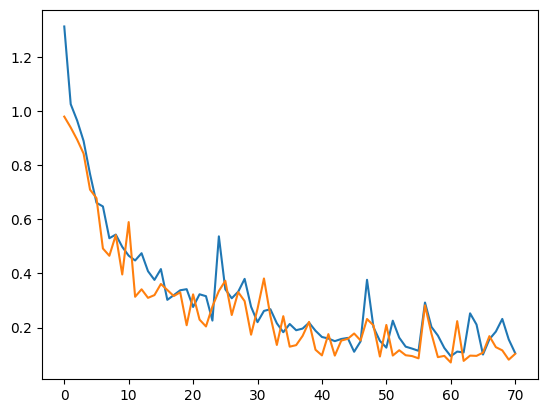

In [59]:
plt.plot(history_fs.history['loss'])
plt.plot(history_fs.history['val_loss'])
plt.show()


In [60]:
pred_fully_supervised = model_fully_supervised.predict(X_test_norm)

In [61]:
print('Accuracy:    ', (np.round(accuracy_score(np.argmax(pred_fully_supervised, axis = 1), y_test), 3)))
print('F1 score:    ', (np.round(f1_score(np.argmax(pred_fully_supervised, axis = 1), y_test, average = 'macro'), 3)))
print('UAR:         ', (np.round(recall_score(np.argmax(pred_fully_supervised, axis = 1), y_test, average = 'macro'), 3)))

Accuracy:     0.977
F1 score:     0.971
UAR:          0.969


### Self supervised + Transfer learning

Using self-supervised approach to learn representations from data (pretext model) and then apply transfer learning to use these representations for the target task (downstream model). 

First, we will need a way to create a proxy task for the model to train on. In our case it will be classification of transformation type applied to the signal (if any). 

We apply one of these transormations: horizontal flip, addition of noise, scaling by a certain factor.

In [62]:
# Horizontal Flipping
def hor_filp(signal):
    hor_flipped = np.flip(signal)
    return hor_flipped

In [63]:
# adding noise    
# created using: https://stackoverflow.com/a/53688043/10700812 

def add_noise_with_SNR(signal, noise_amount):
    target_snr_db = noise_amount #20
    x_watts = signal ** 2                       # Calculate signal power and convert to dB 
    
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)   # Calculate noise then convert to watts
    
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    mean_noise = 0
    
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))     # Generate an sample of white noise
    
    noised_signal = signal + noise_volts        # noise added signal

    return noised_signal 

In [64]:
# Signal Scaling
def scaled(signal, factor):
    scaled_signal = signal * factor
    return scaled_signal

In [65]:
# Performs transformations and creates artificial labels.
def transform_data(X):
    X_noised = np.zeros(X.shape)
    X_scaled = np.zeros(X.shape)
    X_flipped = np.zeros(X.shape)

    for i in range(X.shape[0]):
        X_noised[i,:] = add_noise_with_SNR(X[i,:], 20)
        X_scaled[i,:] = scaled(X[i,:], 1.1)
        X_flipped[i,:] = hor_filp(X[i,:])
    
    full_data = np.concatenate((X, X_noised, X_scaled, X_flipped))
    full_labels = np.concatenate((np.full(X.shape[0], 0),
                                  np.full(X.shape[0], 1),
                                  np.full(X.shape[0], 2),
                                  np.full(X.shape[0], 3)))
    
    return full_data, full_labels

In [66]:
# Transform data and get artificial labels
X_train_transformed, y_train_transformed = transform_data(X_train_norm)
X_devel_transformed, y_devel_transformed = transform_data(X_devel_norm)

In [67]:
# Perform one hot encoding for labels
y_train_transformed_one_hot = one_hot_encoding(y_train_transformed, 4)
y_devel_transformed_one_hot = one_hot_encoding(y_devel_transformed, 4)

In [68]:
# Create a model
inputs, outputs = create_graph(input_shape = 2560, num_classes = 4)
model_pretext = keras.Model(inputs, outputs)

In [69]:
# Optimizer and callbacks (to stop the training when the development loss does not decrease)
opt = keras.optimizers.Adam(learning_rate = 0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            patience = 10, 
                                            restore_best_weights = True)

In [70]:
# Compiling the model
model_pretext.compile(optimizer = opt, loss = 'categorical_crossentropy')

In [71]:
model_pretext.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2560, 1)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2529, 32)          1056      
                                                                 
 batch_normalization_4 (Batc  (None, 2529, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 2529, 32)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 2498, 32)          32800     
                                                                 
 batch_normalization_5 (Batc  (None, 2498, 32)         128       
 hNormalization)                                           

In [72]:
history = model_pretext.fit(X_train_transformed, y_train_transformed_one_hot, 
                            validation_data = (X_devel_transformed, y_devel_transformed_one_hot),
                            callbacks = [callback], 
                            epochs = 100, 
                            batch_size = 32, 
                            verbose = 1)

Epoch 1/100
253/253 [==============================] - 12s 40ms/step - loss: 1.0356 - val_loss: 1.2647
Epoch 2/100
253/253 [==============================] - 9s 36ms/step - loss: 0.4035 - val_loss: 0.4058
Epoch 3/100
253/253 [==============================] - 10s 38ms/step - loss: 0.3525 - val_loss: 0.3703
Epoch 4/100
253/253 [==============================] - 10s 38ms/step - loss: 0.3209 - val_loss: 0.4606
Epoch 5/100
253/253 [==============================] - 10s 40ms/step - loss: 0.3113 - val_loss: 0.3641
Epoch 6/100
253/253 [==============================] - 10s 40ms/step - loss: 0.3216 - val_loss: 0.3783
Epoch 7/100
253/253 [==============================] - 10s 41ms/step - loss: 0.2685 - val_loss: 0.2638
Epoch 8/100
253/253 [==============================] - 9s 37ms/step - loss: 0.2427 - val_loss: 0.5398
Epoch 9/100
253/253 [==============================] - 10s 38ms/step - loss: 0.2132 - val_loss: 0.3198
Epoch 10/100
253/253 [==============================] - 9s 38ms/step - loss

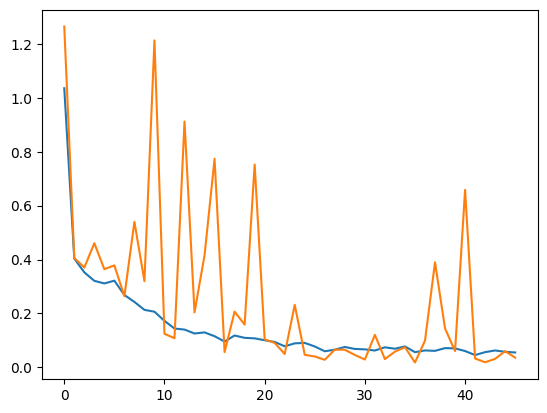

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [74]:
# Stacking the layers
x = layers.Dense(128)(model_pretext.layers[-5].output)
x = layers.Dropout(0.5)(x)
x = layers.Activation(layers.LeakyReLU())(x)
outputs_downstream = layers.Dense(3, 'softmax')(x)

In [75]:
# Create a model
model_downstream = keras.Model(inputs, outputs_downstream)
for i in range(len(model_downstream.layers) - 5):
    model_downstream.layers[i].trainable = False

In [76]:
# Optimizer and callbacks (to stop the training when the development loss does not decrease)
opt = keras.optimizers.Adam(learning_rate = 0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            patience = 10, 
                                            restore_best_weights = True)

In [77]:
# Compile and fit the model
model_downstream.compile(optimizer = opt, loss = 'categorical_crossentropy')


In [78]:
model_downstream.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2560, 1)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2529, 32)          1056      
                                                                 
 batch_normalization_4 (Batc  (None, 2529, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 2529, 32)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 2498, 32)          32800     
                                                                 
 batch_normalization_5 (Batc  (None, 2498, 32)         128       
 hNormalization)                                           

In [79]:
history = model_downstream.fit(X_train_norm, 
                               y_train_one_hot, 
                               validation_data = (X_devel_norm, y_devel_one_hot), 
                               callbacks = [callback], 
                               epochs = 100,
                               batch_size = 32, 
                               verbose = 2)

Epoch 1/100
64/64 - 2s - loss: 1.2116 - val_loss: 0.9943 - 2s/epoch - 37ms/step
Epoch 2/100
64/64 - 1s - loss: 1.0331 - val_loss: 0.9459 - 1s/epoch - 16ms/step
Epoch 3/100
64/64 - 1s - loss: 0.9988 - val_loss: 0.9388 - 1s/epoch - 16ms/step
Epoch 4/100
64/64 - 1s - loss: 0.9674 - val_loss: 0.9216 - 1s/epoch - 16ms/step
Epoch 5/100
64/64 - 1s - loss: 0.9458 - val_loss: 0.9508 - 1s/epoch - 16ms/step
Epoch 6/100
64/64 - 1s - loss: 0.9302 - val_loss: 0.9055 - 1s/epoch - 16ms/step
Epoch 7/100
64/64 - 1s - loss: 0.9226 - val_loss: 0.8715 - 1s/epoch - 16ms/step
Epoch 8/100
64/64 - 1s - loss: 0.9144 - val_loss: 0.8757 - 1s/epoch - 16ms/step
Epoch 9/100
64/64 - 1s - loss: 0.8842 - val_loss: 0.8488 - 1s/epoch - 16ms/step
Epoch 10/100
64/64 - 1s - loss: 0.8816 - val_loss: 0.8296 - 989ms/epoch - 15ms/step
Epoch 11/100
64/64 - 1s - loss: 0.8717 - val_loss: 0.8397 - 981ms/epoch - 15ms/step
Epoch 12/100
64/64 - 1s - loss: 0.8621 - val_loss: 0.8023 - 991ms/epoch - 15ms/step
Epoch 13/100
64/64 - 1s - lo

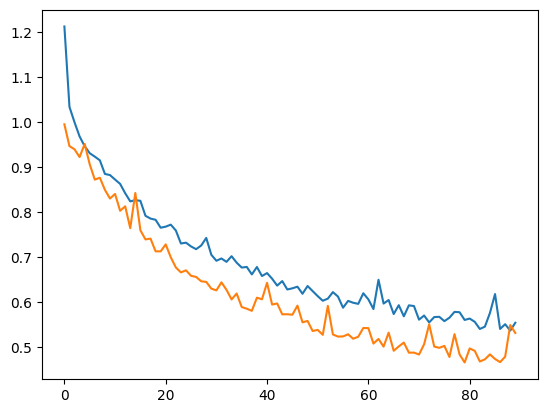

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [81]:
pred_downstream = model_downstream.predict(X_test_norm)

In [82]:
print('Accuracy:    ', (np.round(accuracy_score(np.argmax(pred_downstream, axis = 1), y_test), 3)))
print('F1 score:    ', (np.round(f1_score(np.argmax(pred_downstream, axis = 1), y_test, average = 'macro'), 3)))
print('UAR:         ', (np.round(recall_score(np.argmax(pred_downstream, axis = 1), y_test, average = 'macro'), 3)))

Accuracy:     0.813
F1 score:     0.716
UAR:          0.812


In [83]:
print('Self supervised UAR:     ', (np.round(recall_score(np.argmax(pred_downstream, axis = 1), y_test, average = 'macro'), 3)))
print('Fully supervised UAR:    ', (np.round(recall_score(np.argmax(pred_fully_supervised, axis = 1), y_test, average = 'macro'), 3)))

Self supervised UAR:      0.812
Fully supervised UAR:     0.969


In [84]:
self_supervised = pd.read_csv('results_cv/self_supervised.csv', index_col = 0)
fully_supervised = pd.read_csv('results_cv/fully_supervised.csv', index_col = 0)
classical = pd.read_csv('results_cv/classical.csv', index_col = 0)

In [85]:
# Extract Mean over Cross Validation Partitions
self_supervised_mean = np.mean(self_supervised, axis = 0)
fully_supervised_mean = np.mean(fully_supervised, axis = 0)
classical_mean = np.mean(classical, axis = 0)

x = np.arange(3)

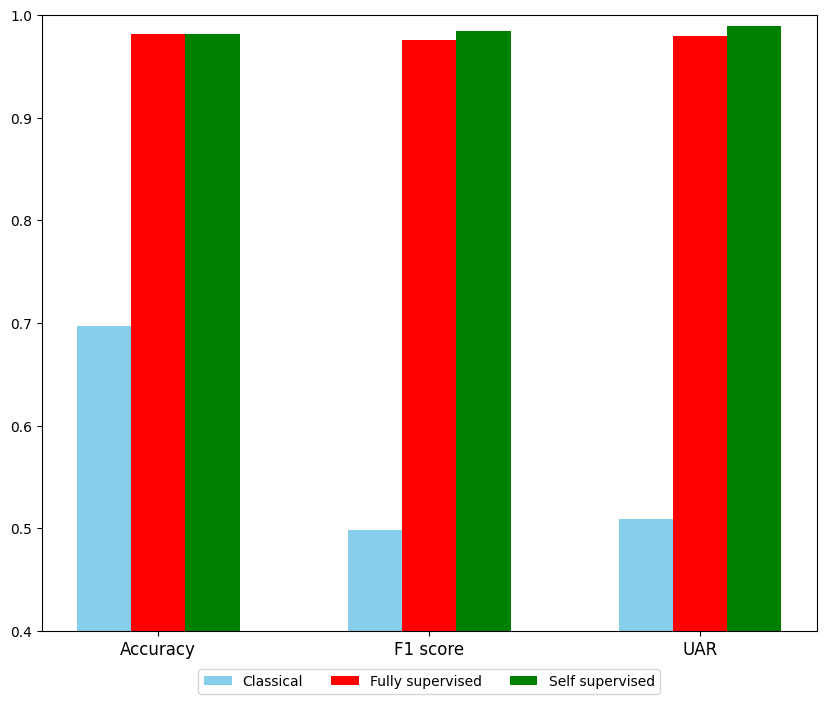

In [86]:
plt.figure(figsize=(10,8))
plt.bar(x - 0.2, classical_mean, width = 0.2, color = "skyblue", label = 'Classical')
plt.bar(x, fully_supervised_mean, width = 0.2, color = "red", label = 'Fully supervised')
plt.bar(x + 0.2, self_supervised_mean, width = 0.2, color = "green", label = 'Self supervised')

plt.ylim([0.4, 1])
plt.xticks([0, 1, 2], ['Accuracy', 'F1 score', 'UAR'], size = 12)

plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()